# The SVRG algorithm


The SVRG algorithm (stochastic variance-reduced gradient REF) is very similar to the SAGA algorithm. Its main advantage is that it does 

As before, we consider the problem of minimizing a finite sum of convex terms:
$$
\text{argmin}_{\theta} \frac{1}{n} \sum_{i=1}^n l_i(\theta)
$$

The basic algorithm is relies on two moving quantities: a vector of coefficients $\theta \in \mathbb{R}^p$ and a table $g \in \mathbb{R}^{n \times p}$ to store the previous gradients. Then the basic iteration is given by the recursion 

$$
\theta^+ = \theta - \gamma (\nabla l_i(\theta) - \nabla l_i(\tilde{\theta}) + \nabla l(\tilde{\theta}))
$$

where at a given interval (say once per epoch), we update $\tilde{\theta} = \theta$ and compute $\nabla l(\tilde{\theta}) = \frac{1}{n}\sum_i \nabla l_i(\theta)$.


<span style="color: red; font-weight: bold" />Task 1: implement this algorithm and check for convergence. Below is a template for this following the SAGA algorithm.</span>

<span style="color: red; font-weight: bold" />Task 2: Decorate with @njit for efficiency.</span>

<span style="color: red; font-weight: bold" />Task 3: Compare with SAGA in terms of number of epochs.</span>


### References

[DSOML Course slides 4](http://marcocuturi.net/Teaching/ENSAE/2017/DSOML/DSOML4.pdf)

Johnson, Rie, and Tong Zhang. ["Accelerating stochastic gradient descent using predictive variance reduction."](https://papers.nips.cc/paper/4937-accelerating-stochastic-gradient-descent-using-predictive-variance-reduction.pdf) Advances in Neural Information Processing Systems. 2013.




In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we will reuse the same set up as for SGD

np.random.seed(0)

n_samples, n_features = 100, 10
A = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = A.dot(w) + np.random.randn(n_samples)
step_size = 1.0 / (3 * np.max((A * A).sum(1)))


def func(theta):
    return 0.5 * np.sum((b - np.dot(A, theta)) ** 2)

def grad(theta):
    return - A.T.dot(b - np.dot(A, theta))

def partial_grad(theta, i):
    return - A[i] * (b[i] - np.dot(A[i], theta))

In [12]:
from numba import njit

@njit
def grad_jit(theta):
    return - np.dot(A.T, b - np.dot(A, theta)) / n_samples

@njit
def partial_grad_jit(theta, i):
    return - A[i] * (b[i] - np.dot(A[i], theta))

@njit
def SVRG(A, b, max_iter=100):

    # .. initial guess (could be anything) ..
    theta_k = np.zeros(n_features)
    theta_tilde = theta_k.copy()
#     grad_avg = grad_jit(theta_tilde)

    # .. to keep track of the gradient (for plotting purposes) ..
    grad_history = np.ones(max_iter)

    # .. main loop ..
    for i in range(n_samples * max_iter):
        # .. save gradient (for plotting purposes) every epoch ..
        if i % n_samples == 0:
            theta_tilde = theta_k.copy()
            grad_avg = grad_jit(theta_tilde)
            grad_history[i // n_samples] = np.linalg.norm(grad_jit(theta_k))

        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)

        # .. compute and apply SVRG update rule ..
        cur_grad = partial_grad_jit(theta_k, idx)
        prev_grad = partial_grad_jit(theta_tilde, idx)
        svrg_update = cur_grad - prev_grad + grad_avg
        theta_k = theta_k - step_size * svrg_update


    return theta_k, grad_history

sol, grad_history = SVRG(A, b)

In [16]:
from numba import njit


@njit
def grad_jit(theta):
    return - np.dot(A.T, b - np.dot(A, theta)) / n_samples

@njit
def partial_grad_jit(theta, i):
    return - A[i] * (b[i] - np.dot(A[i], theta))

@njit
def SAGA_jit(A, b, max_iter=100):

    # .. initial guess (could be anything) ..
    theta_k = np.zeros(n_features)

    # .. initialization for historial gradients ..
    old_grad = np.zeros((n_samples, n_features))
    mean_grad = np.zeros(n_features)

    # .. to keep track of the gradient (for plotting purposes) ..
    grad_history = np.ones(max_iter)

    # .. main loop ..
    for i in range(n_samples * max_iter):
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)

        # .. compute saga update rule ..
        cur_grad = partial_grad_jit(theta_k, idx)
        saga_update = cur_grad - old_grad[idx] + mean_grad
        mean_grad += (cur_grad - old_grad[idx]) / n_samples

        # .. make update ..
        theta_k = theta_k - step_size * saga_update

        # .. save historical gradients ..
        old_grad[idx] = cur_grad

        # .. save gradient (for plotting purposes) every epoch ..
        if i % n_samples == 0:
            grad_history[i // n_samples] = np.linalg.norm(grad_jit(theta_k))

    return theta_k, grad_history

sol_jit, grad_history_saga = SAGA_jit(A, b)

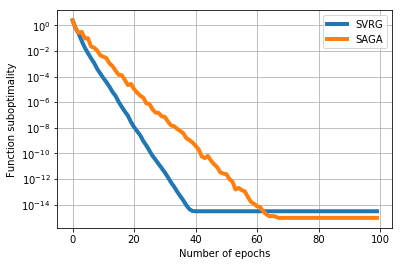

In [18]:
plt.plot(grad_history, lw=4, label='SVRG')
plt.plot(grad_history_saga, lw=4, label='SAGA')
plt.grid()
plt.legend()
plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()